In [140]:
import os
from pycocotools.coco import COCO
from transformers import AutoImageProcessor, AutoModelForObjectDetection, Trainer
from functools import partial
import argparse
import utils
import dataset
import train_eval
from glob import glob
import torch
from tqdm import tqdm
import albumentations as A
import numpy as np
import pandas as pd

In [141]:
model_path = '../../../transformers/Dongjin/1011_model_search/result/1015/jozhang97/deta-swin-large_3_img_size_720'
coco_dir_path = '../../../Split_data'
device = 'cuda'

checkpoint_path = utils.find_checkpoint_path(model_path)
run_name = os.path.split(model_path)[-1]
json_path = os.path.join(model_path, run_name + '.json')

conf = utils.read_json(json_path)
conf['coco_dir_path'] = coco_dir_path
image_processor = AutoImageProcessor.from_pretrained(checkpoint_path)

valid_info_path = os.path.join(conf['coco_dir_path'], conf['valid_info_name'])
coco_valid = COCO(valid_info_path)
valid = dataset.COCO2dataset(conf['data_dir_path'], coco_valid, range(2))

model = AutoModelForObjectDetection.from_pretrained(checkpoint_path)
model.to(device)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


DetaForObjectDetection(
  (model): DetaModel(
    (backbone): DetaBackboneWithPositionalEncodings(
      (model): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                      (value): Linear(in_features=1

In [142]:
def test_eval(conf, model, image_processor, coco_data, data, result_path):
    batch_size = 8

    image_names = []
    prediction_strings = []
    batch_indices = get_batch_indices(batch_size, len(data))

    for batch_index in tqdm(batch_indices):
        batch = data[batch_index]
        image_name, prediction_string = get_predictions(batch, coco_data, model, image_processor)
        
        image_names.extend(image_name)
        prediction_strings.extend(prediction_string)

    submission = pd.DataFrame()
    submission['PredictionString'] = prediction_strings
    submission['image_id'] = image_names
    submission.to_csv(result_path, index=None)


def get_batch_indices(batch_size, n):
    i = 0
    batch_index = []
    batch_indices = []

    while True:
        if (i == n): 
            batch_indices.append(batch_index)
            break

        batch_index.append(i)

        if (len(batch_index) % batch_size == 0):
            batch_indices.append(batch_index)
            batch_index = []
            
        i += 1  

    return batch_indices
        

def get_predictions(batch, coco_data, model, image_processor):
    threshold = 0.05
    device = "cuda"

    with torch.no_grad():
        images = batch['image']
        image_ids = batch['image_id']
        image_infos = coco_data.loadImgs(image_ids)

        inputs = image_processor(images=images, return_tensors="pt")
        outputs = model(**inputs.to(device))
        target_sizes = [image.size for image in images]
        results = image_processor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)
        
        image_names = [image_info['file_name'] for image_info in image_infos]
        prediction_strings = []

        for result in results:
            _, indices = torch.sort(result['scores'], descending=True)
            result["scores"] = result["scores"][indices].detach().cpu().numpy() 
            result["labels"] = result["labels"][indices].detach().cpu().numpy() 
            result["boxes"] = result["boxes"][indices].detach().cpu().numpy() 

            prediction_string = ''

            for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
                prediction_string += str(label) + ' ' + str(score) + ' ' + str(box[0]) + ' ' + str(
                        box[1]) + ' ' + str(box[2]) + ' ' + str(box[3]) + ' '

            prediction_strings.append(prediction_string)
        
        return image_names, prediction_strings

In [143]:
get_predictions(valid, coco_valid, model, image_processor)

(['train/0056.jpg', 'train/0057.jpg'],
 ['1 0.74902475 13.338066 315.38403 245.64087 613.4214 3 0.74576205 541.34985 710.9199 614.6907 833.46875 0 0.7305947 301.7931 207.88835 558.94147 540.9142 0 0.715711 556.37665 136.66344 938.57074 564.4306 5 0.7060543 928.86523 218.35143 1021.38525 309.68896 5 0.65895987 507.86136 392.82693 673.7927 668.569 2 0.4995282 591.292 345.3098 808.68445 623.18604 3 0.44174692 248.49477 441.81137 365.69534 517.5322 4 0.37503448 248.63914 442.02933 366.09192 517.4656 5 0.29054898 248.63914 442.02933 366.09192 517.4656 5 0.25949 591.13104 345.65375 808.9798 622.7851 0 0.1668966 591.6599 345.23883 808.9894 623.27954 1 0.16162045 591.13104 345.65375 808.9798 622.7851 4 0.1608732 928.88904 218.50906 1021.33154 309.87643 5 0.15587173 592.0037 390.97113 697.0971 621.3024 0 0.14662427 422.50815 137.97552 941.1393 596.14905 5 0.1450923 505.41507 347.67612 808.6914 639.6221 3 0.14394103 928.88904 218.50906 1021.33154 309.87643 8 0.141037 541.34985 710.9199 614.6907 

In [144]:
TTA1 = []

In [145]:
batch = valid
coco_data = coco_valid
threshold = 0.05
device = "cuda"

with torch.no_grad():
    images = [np.array(image) for image in batch['image']]
    image_ids = batch['image_id']
    image_infos = coco_data.loadImgs(image_ids)

    inputs = image_processor(images=images, return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = [image.shape for image in images]
    results = image_processor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)
    
    image_names = [image_info['file_name'] for image_info in image_infos]
    prediction_strings = []

    # 결과 score 순으로 정렬하기 
    for result in results:
        _, indices = torch.sort(result['scores'], descending=True)
        result["scores"] = result["scores"][indices].detach().cpu().numpy() 
        result["labels"] = result["labels"][indices].detach().cpu().numpy() 
        result["boxes"] = result["boxes"][indices].detach().cpu().numpy() 

        prediction_string = ''

        for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
            prediction_string += str(label) + ' ' + str(score) + ' ' + str(box[0]) + ' ' + str(
                    box[1]) + ' ' + str(box[2]) + ' ' + str(box[3]) + ' '

        prediction_strings.append(prediction_string)

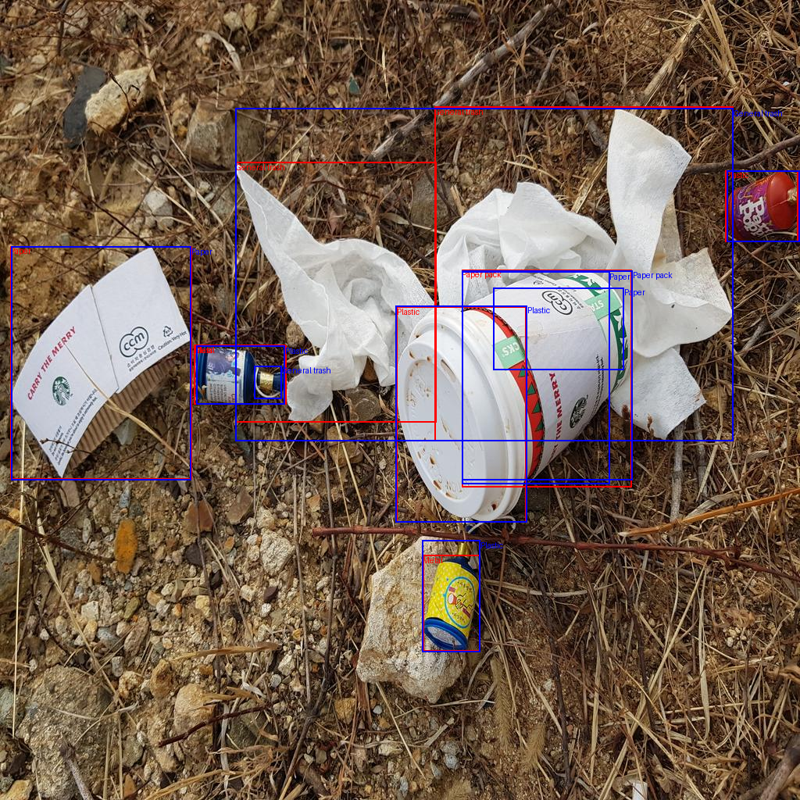

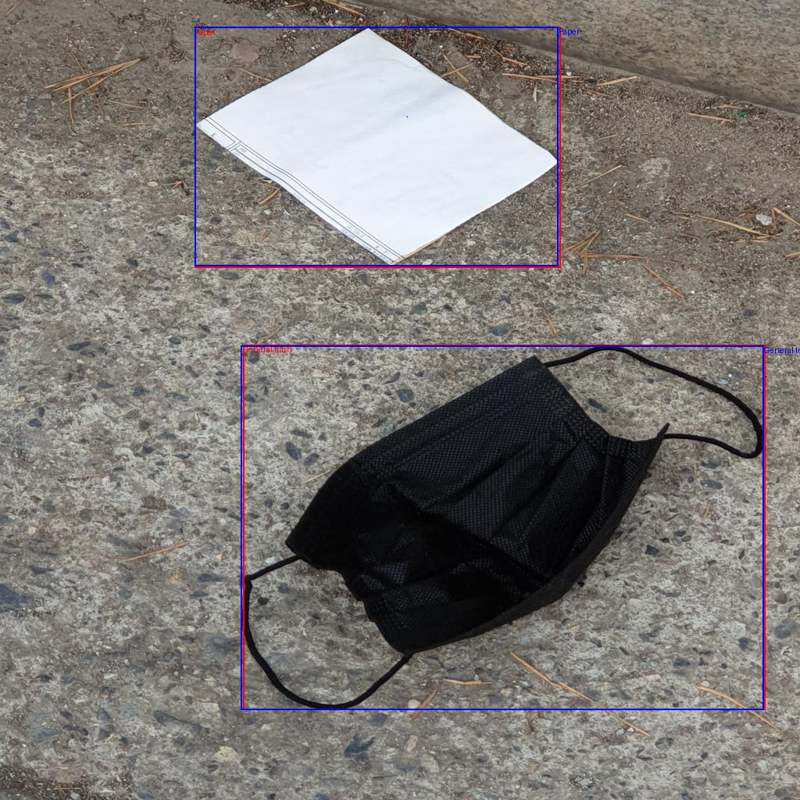

In [146]:
from PIL import Image, ImageDraw


for image, preds, gts in zip(batch['image'], results, batch['objects']):
    scores_preds = preds['scores'] # predictions
    labels_preds = preds['labels']
    boxes_preds = preds['boxes']

    boxes_gts = gts['bbox'] # ground truths
    boxes_gts = [[x, y, x+w, y+h] for x, y, w, h in boxes_gts] # Pascal 형식을 COCO 형식으로 변환
    labels_gts = gts['category']

    draw = ImageDraw.Draw(image)

    for score, label, box in zip(scores_preds, labels_preds, boxes_preds):

        if score < 0.3: 
            continue
        x1, y1, x2, y2 = tuple(box)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=2)
        draw.text((x1, y1), model.config.id2label[label.item()], fill="red")

    for label, box in zip(labels_gts, boxes_gts):
        x1, y1, x2, y2 = tuple(box)

        draw.rectangle((x1, y1, x2, y2), outline="blue", width=2)
        draw.text((x2, y1), model.config.id2label[label], fill="blue")
    
    image.resize((800, 800)).show()


In [147]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)

    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
    
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    return (xB - xA + 1) * (yB - yA + 1)

def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    if boxesIntersect(boxA, boxB) is False:
        return 0
    